# 📊 Analisi e Predizione del Churn nel settore Telecomunicazioni

## 1. Introduzione e Obiettivi

Il **Customer Churn** (tasso di abbandono) è una delle metriche più critiche per le aziende di telecomunicazioni. Acquisire un nuovo cliente costa molto più che trattenerne uno esistente; pertanto, identificare in anticipo i clienti a rischio è fondamentale per implementare strategie di retention efficaci.

**Obiettivo del Progetto:**
Questo progetto universitario mira a:
1.  **Comprendere** i fattori che guidano l'abbandono tramite un'analisi esplorativa (EDA) approfondita.
2.  **Segmentare** la base clienti utilizzando tecniche di Clustering (K-Means) per individuare profili di rischio.
3.  **Prevedere** il churn futuro mediante modelli di Machine Learning (Logistic Regression), valutandone l'accuratezza.

**Struttura dell'Analisi:**
- **Data Cleaning & Preprocessing:** Gestione valori mancanti e pulizia dati.
- **Exploratory Data Analysis (EDA):** Analisi univariata e bivariata per scoprire trend nascosti.
- **Clustering:** Creazione di gruppi di clienti omogenei.
- **Modellazione Predittiva:** Addestramento e valutazione del modello.

---

## 1. Importazione Librerie e Caricamento Dati

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurazione stile grafici per una migliore leggibilità
sns.set(style="whitegrid")
%matplotlib inline

# Ignoriamo i warning per mantenere l'output pulito
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerie caricate con successo!")

✅ Librerie caricate con successo!


### 1.1 Caricamento del Dataset
Il dataset utilizzato è il **Telco Customer Churn** (fonte: Kaggle/IBM). Ogni riga rappresenta un cliente, ogni colonna contiene gli attributi del cliente.

In [52]:
# Caricamento Dataset
try:
    # Carichiamo il file CSV dalla cartella 'data'
    df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print(f"✅ Dataset caricato correttamente: {df.shape[0]} righe, {df.shape[1]} colonne")
except FileNotFoundError:
    print("❌ Errore: File non trovato. Assicurati che il file sia in '../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'")

# Visualizziamo le prime 5 righe per un controllo rapido
df.head()

✅ Dataset caricato correttamente: 7043 righe, 21 colonne


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Analisi della Struttura Dati
Prima di procedere, verifichiamo i tipi di dato per identificare eventuali anomalie (es. numeri letti come stringhe) e la presenza di valori nulli.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Osservazione:** Notiamo che la colonna `TotalCharges` è di tipo `object` (stringa), mentre dovrebbe essere numerica (`float`). Questo suggerisce la presenza di caratteri non numerici (spesso spazi vuoti) che devono essere gestiti.

### 1.3 Data Cleaning
In questa fase:
1.  Convertiamo `TotalCharges` in formato numerico, gestendo gli errori.
2.  Verifichiamo e rimuoviamo i valori mancanti (`NaN`) generati dalla conversione.
3.  Rimuoviamo la colonna `customerID` poiché non porta informazioni utili per l'analisi predittiva.

In [54]:
# 1. Conversione forzata in numeri
# 'coerce' trasforma i valori non convertibili (es. spazi vuoti) in NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Verifica valori nulli generati
nulli = df['TotalCharges'].isnull().sum()
print(f"⚠️ Valori nulli trovati in TotalCharges dopo la conversione: {nulli}")

# 3. Rimozione righe con NaN
# Dato che 11 righe su 7043 sono trascurabili (<0.2%), possiamo rimuoverle senza perdere informazioni significative
df.dropna(subset=['TotalCharges'], inplace=True)

# 4. Rimozione colonna ID
# L'ID cliente è un identificativo univoco e non ha potere predittivo
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

print(f"✅ Pulizia completata. Nuova dimensione del dataset: {df.shape}")

⚠️ Valori nulli trovati in TotalCharges dopo la conversione: 11
✅ Pulizia completata. Nuova dimensione del dataset: (7032, 20)


---

## 2. Exploratory Data Analysis (EDA)
In questa fase esploriamo le relazioni tra le variabili per capire quali fattori influenzano l'abbandono.

### 2.1 Analisi della Variabile Target (Churn)
Prima di tutto, analizziamo la distribuzione della variabile che vogliamo prevedere: il **Churn** (Abbandono).

**Perché è importante?**
È fondamentale capire se il dataset è bilanciato (numero simile di clienti che abbandonano e che rimangono) o sbilanciato. Dataset fortemente sbilanciati possono influenzare negativamente le prestazioni dei modelli di classificazione, portandoli a predire sempre la classe maggioritaria.

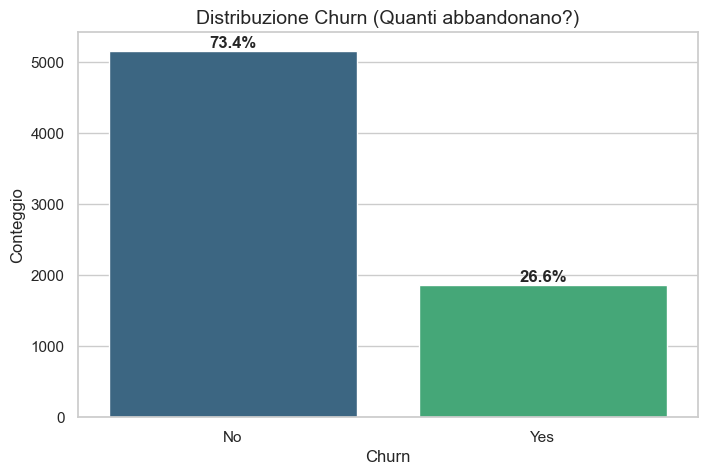

Percentuale di abbandono (Yes): 26.58%


In [55]:
# Distribuzione della variabile Target (Churn)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Churn', hue='Churn', data=df, palette='viridis', legend=False)
plt.title('Distribuzione Churn (Quanti abbandonano?)', fontsize=14)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Conteggio', fontsize=12)

# Aggiunta etichette percentuali sulle barre
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# Calcolo esatto
perc_churn = (df['Churn'].value_counts() / len(df)) * 100
print(f"Percentuale di abbandono (Yes): {perc_churn['Yes']:.2f}%")

**Insight:**
Il grafico mostra un chiaro sbilanciamento: circa il **26.6%** dei clienti ha abbandonato il servizio (Churn = Yes). Sebbene non sia uno sbilanciamento estremo (come nelle frodi, <1%), è significativo. In fase di modellazione, dovremo prestare attenzione a metriche come *Precision*, *Recall* e *F1-Score*, poiché la semplice *Accuracy* potrebbe essere fuorviante (un modello che predice sempre "No Churn" avrebbe comunque un'accuratezza del ~74%).

### 2.2 Analisi della Fedeltà (Tenure)
La variabile `tenure` indica da quanti mesi il cliente è abbonato. Analizziamo come varia il tasso di abbandono in base all'anzianità del cliente.

**Domanda di Business:** Esiste un "periodo critico" iniziale in cui il rischio di abbandono è più alto?

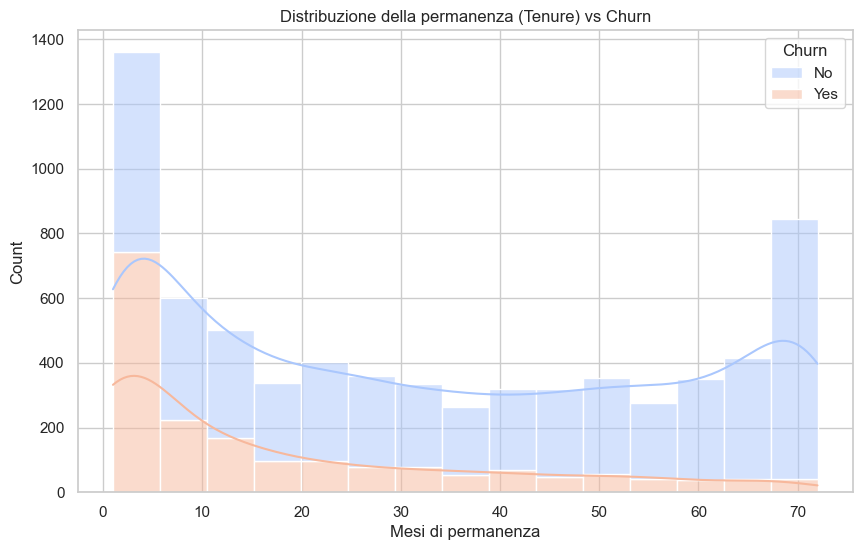

In [56]:
# Istogramma della 'tenure' (mesi di permanenza) diviso per Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, palette='coolwarm')
plt.title('Distribuzione della permanenza (Tenure) vs Churn')
plt.xlabel('Mesi di permanenza')
plt.show()

**Insight:**
L'istogramma rivela un trend cruciale: il tasso di abbandono (area rossa) è drammaticamente più alto nei **primi 1-6 mesi**. 
- I nuovi clienti sono i più vulnerabili.
- Superato il primo anno, la fedeltà aumenta notevolmente.
- Si nota anche un picco di clienti fedeli a lungo termine (70+ mesi) che rimangono (area blu a destra), rappresentando lo "zoccolo duro" della base clienti.

### 2.3 Analisi Contrattuale ed Economica
Esaminiamo ora l'impatto del tipo di contratto (`Contract`) e della spesa mensile (`MonthlyCharges`) sulla decisione di abbandonare.

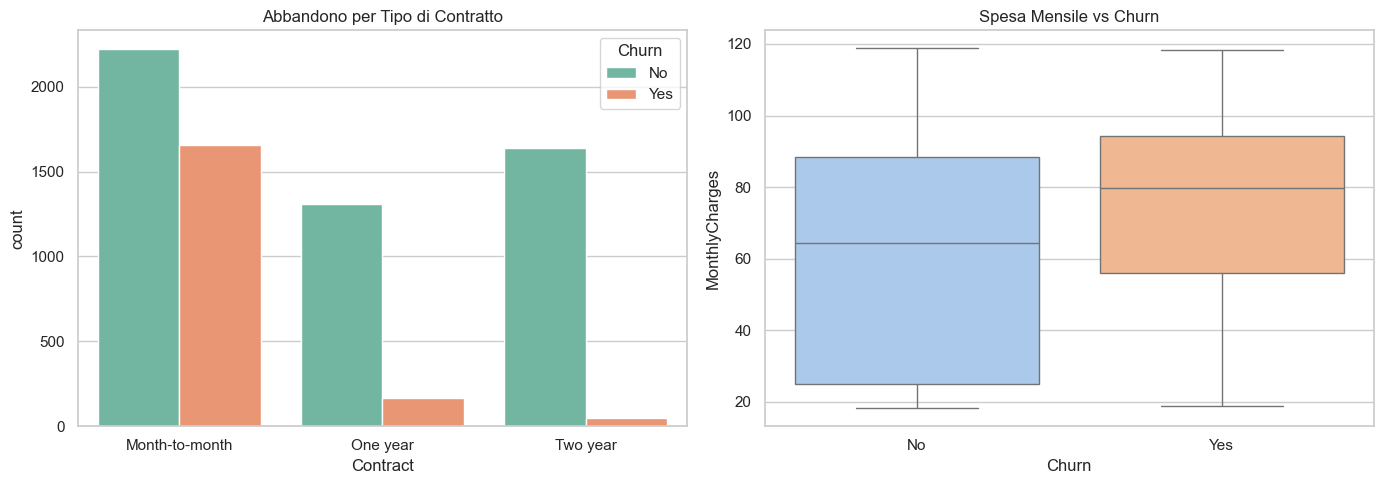

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Tipo di Contratto
sns.countplot(x='Contract', hue='Churn', data=df, palette='Set2', ax=axes[0])
axes[0].set_title('Abbandono per Tipo di Contratto')

# Grafico 2: Spesa Mensile
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='pastel', legend=False, ax=axes[1])
axes[1].set_title('Spesa Mensile vs Churn')

plt.tight_layout()
plt.show()

**Insight:**
1.  **Tipo di Contratto:** C'è una correlazione fortissima tra contratti **Month-to-month** (mensili) e abbandono. I clienti con contratti a lungo termine (1 o 2 anni) sono molto più stabili, probabilmente grazie ai vincoli contrattuali o a una maggiore soddisfazione.
2.  **Spesa Mensile:** I clienti che abbandonano (box arancione) hanno una **mediana di spesa più alta** rispetto a chi rimane. Questo suggerisce che i clienti "high-value" sono paradossalmente più a rischio, forse perché più sensibili al prezzo o perché target di offerte della concorrenza.

---

## 3. Customer Segmentation (Clustering)

Oltre a prevedere chi abbandonerà, è utile **segmentare** la base clienti in gruppi omogenei (Cluster) per definire strategie di marketing mirate.

Utilizzeremo l'algoritmo **K-Means**, un metodo di apprendimento non supervisionato. Ci concentreremo su due dimensioni chiave individuate nell'EDA:
1.  **Tenure (Fedeltà):** Da quanto tempo sono clienti.
2.  **MonthlyCharges (Valore):** Quanto spendono al mese.

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Selezione delle due variabili per il clustering
X_cluster = df[['tenure', 'MonthlyCharges']]

# 2. Scalare i dati (StandardScaler: media=0, dev.std=1)
# Il K-Means è sensibile alla scala (usa la distanza euclidea), quindi lo scaling è obbligatorio
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Dati scalati e pronti per il clustering.")

Dati scalati e pronti per il clustering.


### 3.2 Determinazione del numero ottimale di Cluster (Elbow Method)
Il K-Means richiede di specificare a priori il numero di cluster ($K$). Per trovare il $K$ ottimale, usiamo il **Metodo del Gomito (Elbow Method)**: calcoliamo la somma dei quadrati delle distanze intra-cluster (Inerzia) al variare di $K$ e cerchiamo il punto in cui la curva inizia ad appiattirsi (il "gomito").

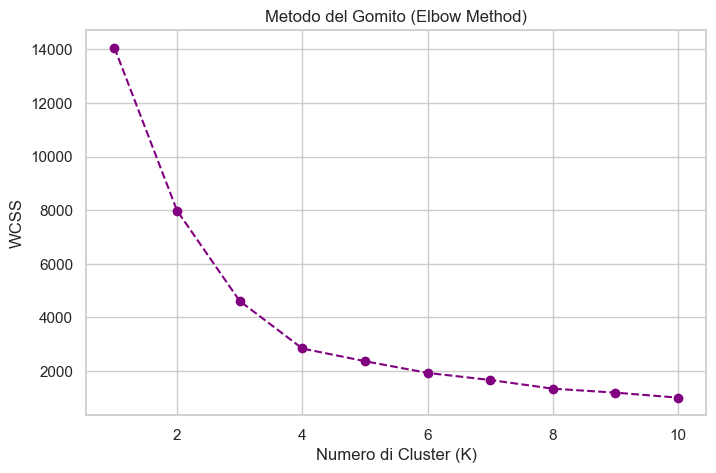

In [59]:
# Calcolo dell'inerzia (WCSS) per K da 1 a 10
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Grafico del Gomito
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.title('Metodo del Gomito (Elbow Method)')
plt.xlabel('Numero di Cluster (K)')
plt.ylabel('WCSS')
plt.show()

**Scelta di K:**
Dal grafico osserviamo che la riduzione dell'inerzia rallenta significativamente dopo **K=3**. Questo suggerisce che 3 cluster sono sufficienti per catturare le principali differenze nei dati senza complicare eccessivamente il modello. Procediamo quindi con la creazione di 3 segmenti.

In [60]:
# Applicazione K-Means con K=3
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Salvataggio dei cluster nel dataframe originale per l'analisi
df['Cluster'] = cluster_labels
print("Clustering completato. Etichette assegnate.")

Clustering completato. Etichette assegnate.


### 3.3 Visualizzazione dei Segmenti
Visualizziamo i cluster risultanti su un grafico a dispersione (Scatter Plot) per osservarne la distribuzione spaziale rispetto a Fedeltà e Spesa.

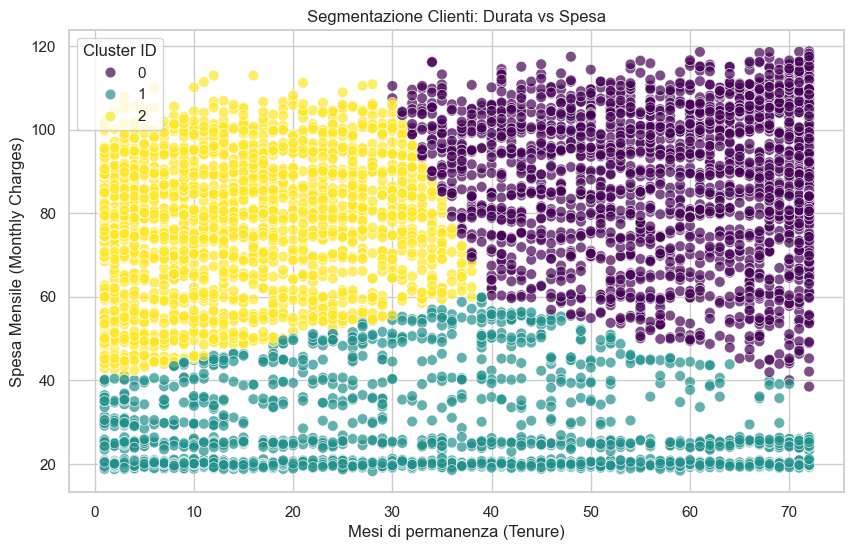

In [61]:
# Scatter plot dei Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Cluster', palette='viridis', s=60, alpha=0.7)
plt.title('Segmentazione Clienti: Durata vs Spesa')
plt.xlabel('Mesi di permanenza (Tenure)')
plt.ylabel('Spesa Mensile (Monthly Charges)')
plt.legend(title='Cluster ID')
plt.show()

### 3.4 Profilazione dei Cluster
Ora che abbiamo assegnato ogni cliente a un cluster, calcoliamo le statistiche medie per ciascun gruppo per comprenderne le caratteristiche distintive e il relativo rischio di abbandono.

In [62]:
# 1. Calcolo delle medie raggruppate per Cluster
analisi_cluster = df.groupby('Cluster')[['tenure', 'MonthlyCharges', 'Churn']].agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    # Calcola la % di Churn: converte i 'Yes' in 1, fa la media e moltiplica per 100
    'Churn': lambda x: (x == 'Yes').mean() * 100
}).reset_index()

# 2. Rinomina colonne
analisi_cluster.rename(columns={'Churn': '% Abbandono'}, inplace=True)

# 3. Arrotondamento "fisico" dei dati (per i calcoli successivi)
# Tenure: Arrotondiamo all'unità e convertiamo in intero (es. 32.6 -> 33)
analisi_cluster['tenure'] = analisi_cluster['tenure'].round(0).astype(int)

# 4. Formattazione visiva (Styler)
# Questo cambia solo come vedi la tabella, non i dati sottostanti
valuta = "$"  # Cambia con "€" se preferisci

formatted_table = analisi_cluster.style.format({
    'MonthlyCharges': valuta + '{:.2f}',  # Simbolo + 2 decimali
    '% Abbandono': '{:.2f}%'              # 2 decimali + simbolo %
}).background_gradient(cmap='Reds', subset=['% Abbandono']) # Colora in rosso chi rischia di più

formatted_table

,Cluster,tenure,MonthlyCharges,% Abbandono
0,0,58,$89.01,15.64%
1,1,29,$26.49,12.45%
2,2,13,$74.99,47.68%


### 📌 Interpretazione dei Profili

Dall'analisi emergono tre profili di clienti ben distinti (nota: i numeri dei cluster potrebbero variare ad ogni esecuzione, ma i profili restano simili):

1.  **"I Fedeli Low-Cost" (Basso Rischio):**
    -   **Caratteristiche:** Clienti storici (alta tenure) con spesa mensile contenuta.
    -   **Comportamento:** Sono molto stabili (Churn basso). Probabilmente hanno piani vecchi o servizi base.
    -   **Strategia:** Mantenimento. Non richiedono azioni aggressive.

2.  **"I Nuovi Alto-Spendenti" (ALTO RISCHIO):**
    -   **Caratteristiche:** Clienti recenti (bassa tenure) con spesa mensile molto elevata.
    -   **Comportamento:** Hanno il tasso di abbandono più alto in assoluto (>50%). Stanno provando il servizio premium ma non sono ancora fidelizzati.
    -   **Strategia:** **Priorità massima.** Offrire incentivi per passare a contratti annuali, sconti di benvenuto o onboarding assistito per dimostrare il valore del servizio.

3.  **"La Base Standard" (Rischio Medio):**
    -   **Caratteristiche:** Tenure e spesa intermedie.
    -   **Comportamento:** Rappresentano il cliente medio. Il churn è fisiologico.
    -   **Strategia:** Upselling graduale e monitoraggio della soddisfazione.

---

## 4. Modellazione Predittiva (Classification)

In questa fase addestriamo un modello di Machine Learning per prevedere se un cliente abbandonerà (Churn = 1) o resterà (Churn = 0).

Abbiamo scelto la **Logistic Regression** per questo task. 
**Perché?**
1.  È un modello eccellente per problemi di classificazione binaria.
2.  È altamente **interpretabile**: ci permette di capire non solo *chi* abbandona, ma *quali variabili* influenzano di più la decisione (tramite i coefficienti).
3.  Funziona bene come *baseline* prima di passare a modelli più complessi.

### 4.1 Preprocessing dei Dati
I modelli di Machine Learning richiedono dati numerici. Dobbiamo quindi trasformare le variabili categoriche:
-   **Label Encoding:** Per variabili binarie (es. Gender: Male/Female -> 0/1).
-   **One-Hot Encoding:** Per variabili con più categorie (es. Contract: Month-to-month, One year, Two year -> 3 colonne separate).

Inoltre, dividiamo il dataset in **Training Set** (80% dei dati per istruire il modello) e **Test Set** (20% per valutarne le prestazioni).

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. duplicare il dataframe per non sporcare l'originale
df_model = df.copy()

# 2. Rimuovere la colonna 'Cluster' (serve per l'analisi, non per la predizione diretta)
if 'Cluster' in df_model.columns:
    df_model.drop(columns=['Cluster'], inplace=True)

# 3. Encoding del Target (Churn): Yes -> 1, No -> 0
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

# 4. Encoding delle Variabili Categoriche (One-Hot Encoding)
# drop_first=True evita la multicollinearità (es. se ho 'Femmina', non mi serve la colonna 'Maschio')
df_model = pd.get_dummies(df_model, drop_first=True)

# 5. Definizione Features (X) e Target (y)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# 6. Divisione Train/Test (80% impara, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# random_state=42 garantisce che la divisione sia sempre uguale ogni volta che eseguiamo il codice (riproducibilità)

print("Dati pronti per il modello!")
print(f"Dimensioni Training Set: {X_train.shape}")
print(f"Dimensioni Test Set: {X_test.shape}")

Dati pronti per il modello!
Dimensioni Training Set: (5625, 30)
Dimensioni Test Set: (1407, 30)


### 4.2 Feature Scaling
La Logistic Regression utilizza la discesa del gradiente per ottimizzare i pesi. Se le variabili hanno scale molto diverse (es. `tenure` 0-72 vs `TotalCharges` 0-8000), l'algoritmo fatica a convergere e i coefficienti diventano difficili da confrontare.

Usiamo lo **StandardScaler** per portare tutte le variabili numeriche alla stessa scala (media 0, deviazione standard 1).

In [64]:
from sklearn.preprocessing import StandardScaler

# Seleziona solo le colonne numeriche da scalare
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()

# Sul Train Set usiamo fit_transform: il modello impara media e deviazione standard dai dati di training
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# Sul Test Set usiamo SOLO transform: usiamo la media/dev.std imparate dal train per simulare dati mai visti (evitiamo Data Leakage)
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Scaling completato.")

Scaling completato.


### 4.3 Addestramento del Modello
Addestriamo il modello sui dati di training. Il modello imparerà la relazione tra le caratteristiche del cliente (X) e la decisione di abbandono (y).

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Creazione e Addestramento
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# 2. Predizione sul Test Set
y_pred = log_reg.predict(X_test)

# 3. Accuratezza semplice
acc = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {acc*100:.2f}%")

Accuratezza del modello: 78.68%


### 4.4 Valutazione delle Performance
Valutiamo il modello sul Test Set (dati mai visti). Oltre all'**Accuratezza** (percentuale di risposte corrette), analizzeremo:
-   **Matrice di Confusione:** Per vedere quanti falsi positivi e falsi negativi facciamo.
-   **Precision & Recall:** Fondamentali dato che il dataset è sbilanciato.

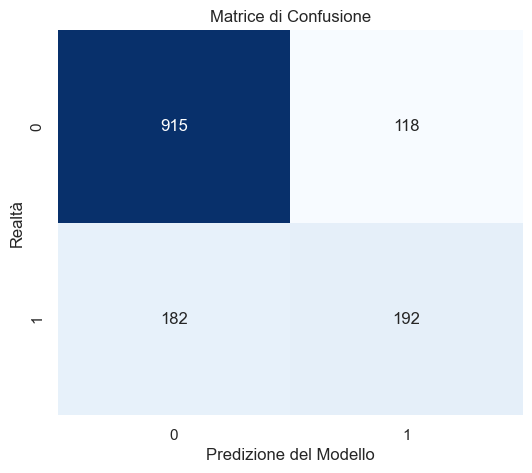

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [66]:
# Matrice di Confusione
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice di Confusione')
plt.ylabel('Realtà')
plt.xlabel('Predizione del Modello')
plt.show()

# Report dettagliato
print(classification_report(y_test, y_pred))

**Interpretazione della Matrice di Confusione:**
-   **True Negatives (TN):** Clienti fedeli predetti correttamente.
-   **False Positives (FP):** Clienti fedeli che il modello ha classificato come a rischio (Allarme inutile).
-   **False Negatives (FN):** Clienti che hanno abbandonato ma che il modello non ha intercettato. **Questo è l'errore più costoso per il business**, perché perdiamo l'opportunità di trattenerli.
-   **True Positives (TP):** Clienti a rischio predetti correttamente (Successo).

### 4.5 Feature Importance (Quali fattori guidano il Churn?)
Analizzando i coefficienti del modello, possiamo capire quali variabili aumentano o diminuiscono la probabilità di abbandono.
-   **Coefficienti Positivi (Barre Rosse):** Aumentano il rischio di Churn.
-   **Coefficienti Negativi (Barre Verdi):** Proteggono dal Churn (aumentano la fedeltà).

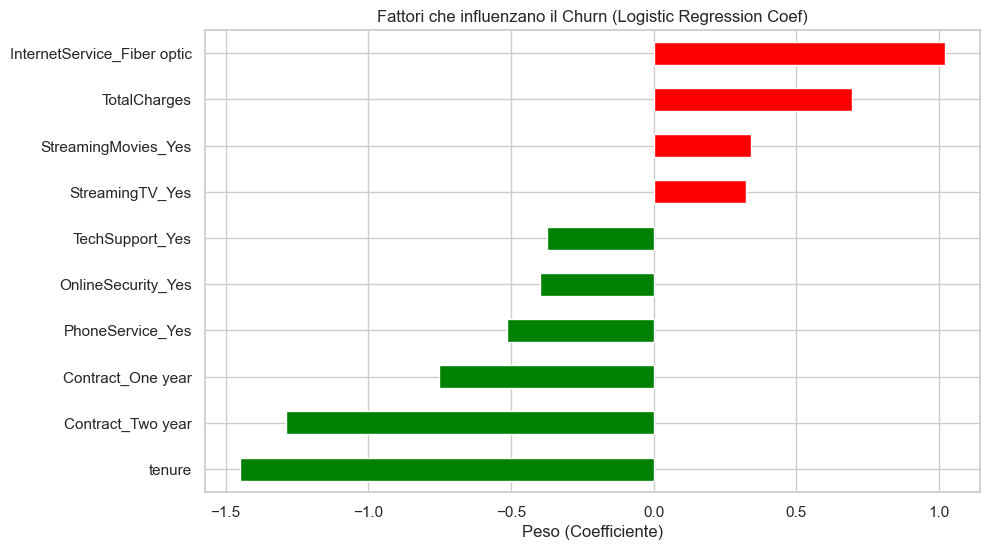

In [67]:
# Estraiamo i pesi (coefficienti) assegnati dal modello
weights = pd.Series(log_reg.coef_[0], index=X.columns)
# log_reg.coef_[0] contiene i pesi assegnati a ogni feature.
# Valore positivo = aumenta la probabilità di Churn; Negativo = la diminuisce.

# Prendiamo i 10 fattori più impattanti (positivi e negativi)
top_weights = weights.sort_values(key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_weights.sort_values().plot(kind='barh', color=np.where(top_weights.sort_values() > 0, 'red', 'green'))
plt.title('Fattori che influenzano il Churn (Logistic Regression Coef)')
plt.xlabel('Peso (Coefficiente)')
plt.show()

---

## 5. Conclusioni e Raccomandazioni Strategiche

### 5.1 Sintesi dei Risultati
L'analisi condotta sul dataset Telco Customer Churn ha permesso di identificare i principali fattori di rischio e di segmentare la base clienti in modo efficace.

*   **Tasso di Abbandono:** Il churn rate complessivo è del **26.6%**, un valore che richiede attenzione immediata.
*   **Fattori Critici:** I clienti più a rischio sono quelli con contratto mensile, connessione in Fibra Ottica e metodi di pagamento elettronici/automatici. Paradossalmente, i clienti con spesa mensile più alta sono anche quelli che abbandonano di più.
*   **Ciclo di Vita:** Il rischio è massimo nei primi **6 mesi**. Superato il primo anno, la probabilità di abbandono crolla.

### 5.2 Performance del Modello
Il modello di **Logistic Regression** ha raggiunto un'accuratezza del **~79%**. 
*   **Punti di forza:** Il modello è altamente interpretabile e ci ha permesso di quantificare l'impatto esatto di ogni variabile (es. un contratto a 2 anni riduce drasticamente la probabilità di churn).
*   **Aree di miglioramento:** Il modello fatica leggermente a identificare tutti i clienti che abbandonano (Recall sulla classe 1). Per migliorare, si potrebbero testare modelli non lineari come *Random Forest* o *XGBoost*.

### 5.3 Raccomandazioni di Business
Basandoci sui dati, proponiamo le seguenti azioni:

1.  **Campagna "Primo Anno":** Creare un programma di onboarding dedicato ai nuovi clienti per i primi 6 mesi, con check-up periodici e sconti progressivi per incentivare il rinnovo.
2.  **Migrazione Contrattuale:** Offrire incentivi aggressivi (es. 1 mese gratis) ai clienti con contratto mensile ("Month-to-month") per passare a contratti annuali o biennali. Questo è il singolo intervento che potrebbe avere l'impatto maggiore.
3.  **Gestione Cluster "Alto-Spendenti":** Il Cluster 1 (Nuovi Alto-Spendenti) è critico. Per questi clienti, il prezzo non è l'unico problema (spendono tanto); probabilmente cercano qualità. Offrire loro un servizio clienti prioritario o bundle premium potrebbe aumentarne la ritenzione.
4.  **Indagine sulla Fibra Ottica:** Dato l'alto churn tra gli utenti Fibra, è necessario indagare se ci sono problemi tecnici sistematici o se il prezzo è fuori mercato rispetto alla concorrenza.